<a href="https://colab.research.google.com/github/RestuAndikha/Task-Final-Task-Home-Credit-Scorecard-Model_Restu/blob/main/Task_%E2%80%A2_%5BFinal_Task%5D_Home_Credit_Scorecard_Model_Restu_Andikha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Problem Research

Dalam industri pembiayaan, keputusan persetujuan kredit memiliki peran krusial
terhadap keberlanjutan bisnis. Kesalahan dalam proses ini dapat menyebabkan dua
risiko utama: meningkatnya kredit bermasalah (default) dan hilangnya peluang
pendapatan akibat penolakan nasabah yang sebenarnya layak.

Oleh karena itu, diperlukan pendekatan berbasis data untuk membantu perusahaan
memprediksi risiko gagal bayar dan meningkatkan kualitas keputusan kredit.


## 2. Goal, Objective, and Metrics

### Goal
Meningkatkan kualitas keputusan persetujuan kredit.

### Objective
Membangun model prediktif untuk mengestimasi probabilitas gagal bayar (default)
nasabah pinjaman.

### Evaluation Metric
AUC-ROC digunakan sebagai metrik utama karena dataset bersifat imbalanced dan
fokus pada kemampuan model dalam membedakan nasabah berisiko tinggi dan rendah.


## 3. Dataset Overview

Dataset yang digunakan berasal dari Home Credit dan terdiri dari data aplikasi
pinjaman serta histori keuangan nasabah.

Dataset utama:
- application_train.csv → Data aplikasi pinjaman dan target default

Dataset pendukung:
- bureau.csv → Riwayat kredit dari lembaga lain
- installments_payments.csv → Riwayat pembayaran cicilan

Dataset bersifat relasional dan mencerminkan kondisi finansial serta perilaku
pembayaran nasabah secara historis.


# 4. Import Library & Load Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


In [ ]:
app = pd.read_csv("application_train.csv")
bureau = pd.read_csv("bureau.csv")
installments = pd.read_csv("installments_payments.csv")

app.head()


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 5. Initial Data Exploration

 Dataset memiliki distribusi target yang tidak seimbang, yang umum terjadi pada kasus risiko kredit.


In [ ]:
app.shape
app['TARGET'].value_counts(normalize=True)
app.isnull().mean().sort_values(ascending=False).head(10)


,0
COMMONAREA_AVG,0.697036
COMMONAREA_MODE,0.697036
COMMONAREA_MEDI,0.697036
NONLIVINGAPARTMENTS_MEDI,0.693943
NONLIVINGAPARTMENTS_MODE,0.693943
NONLIVINGAPARTMENTS_AVG,0.693943
FONDKAPREMONT_MODE,0.685052
LIVINGAPARTMENTS_AVG,0.683376
LIVINGAPARTMENTS_MEDI,0.683376
LIVINGAPARTMENTS_MODE,0.683376


# 6. Data Cleaning & Pre-Processing

Tahapan pre-processing dilakukan untuk memastikan data siap digunakan dalam
pemodelan dengan kualitas fitur yang optimal.


In [ ]:
missing_ratio = app.isnull().mean()
drop_cols = missing_ratio[missing_ratio > 0.6].index
app = app.drop(columns=drop_cols)


In [ ]:
cat_cols = app.select_dtypes(include='object').columns
app = pd.get_dummies(app, columns=cat_cols, drop_first=True)


# 7. Feature Engineering

In [ ]:
installments['DPD'] = installments['DAYS_ENTRY_PAYMENT'] - installments['DAYS_INSTALMENT']
installments['DPD'] = installments['DPD'].apply(lambda x: x if x > 0 else 0)


In [ ]:
inst_agg = installments.groupby('SK_ID_CURR').agg({
    'DPD': ['mean', 'max']
}).reset_index()

inst_agg.columns = ['SK_ID_CURR', 'DPD_MEAN', 'DPD_MAX']
app = app.merge(inst_agg, on='SK_ID_CURR', how='left')


# 8. Data Visualization & Business Insight

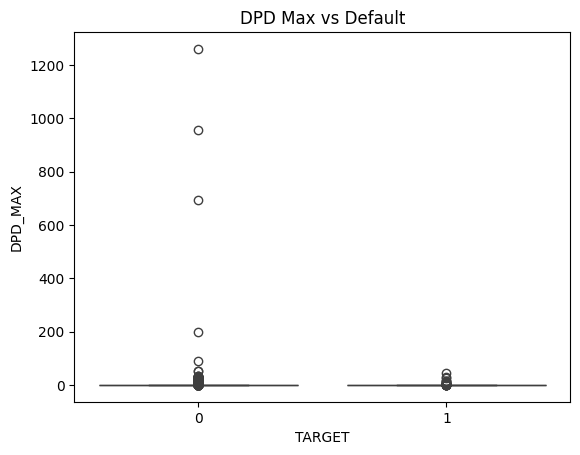

In [ ]:
sns.boxplot(x='TARGET', y='DPD_MAX', data=app)
plt.title("DPD Max vs Default")
plt.show()


# Insight 1 Riwayat Keterlambatan vs Default
Nasabah yang gagal bayar memiliki nilai keterlambatan pembayaran (DPD) yang
lebih tinggi. Hal ini menunjukkan bahwa histori keterlambatan merupakan indikator risiko yang kuat.


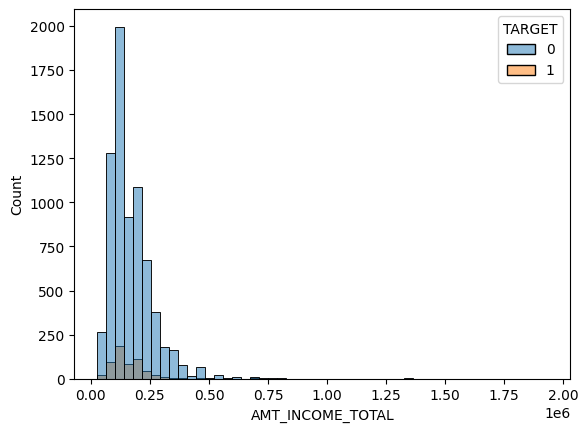

In [ ]:
sns.histplot(app, x='AMT_INCOME_TOTAL', hue='TARGET', bins=50)
plt.show()


# Insight 2 Pendapatan vs Risiko Default
Nasabah dengan pendapatan lebih rendah cenderung memiliki risiko gagal bayar
yang lebih tinggi.


# 9. Data Splitting

In [ ]:
X = app.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = app['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


# 10. Modelling

In [ ]:
from sklearn.impute import SimpleImputer

# Imputer untuk Logistic Regression
imputer = SimpleImputer(strategy='median')

X_train_lr = imputer.fit_transform(X_train)
X_test_lr = imputer.transform(X_test)


In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_lr, y_train)

y_pred_lr = logreg.predict_proba(X_test_lr)[:, 1]
auc_lr = roc_auc_score(y_test, y_pred_lr)

auc_lr


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


np.float64(0.5916550279329609)

In [ ]:
!pip install lightgbm


In [ ]:
import lightgbm as lgb
# Clean feature names
X_train.columns = X_train.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
X_test.columns = X_test.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)


In [ ]:
model = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8,
    random_state=42
)

model.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 478, number of negative: 5730
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8055
[LightGBM] [Info] Number of data points in the train set: 6208, number of used features: 163
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.076997 -> initscore=-2.483860
[LightGBM] [Info] Start training from score -2.483860
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

LGBMClassifier(learning_rate=0.05, max_depth=8, n_estimators=300,
               random_state=42)

# 11. Model Evaluation

In [ ]:
y_pred_lgb = model.predict_proba(X_test)[:,1]
auc_lgb = roc_auc_score(y_test, y_pred_lgb)

auc_lgb


np.float64(0.7058484636871508)

Model LightGBM menunjukkan performa yang lebih baik dibandingkan Logistic
Regression dan dipilih sebagai model final.


# 12. Feature Importance

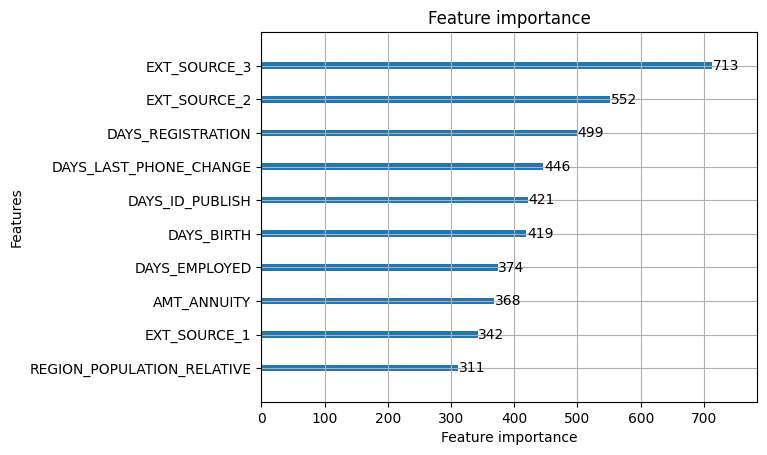

In [ ]:
lgb.plot_importance(model, max_num_features=10)
plt.show()


## 13. Business Recommendation

1. Nasabah dengan riwayat keterlambatan tinggi dapat dikenakan kebijakan
   risk-based approval seperti penyesuaian limit dan suku bunga.

2. Nasabah dengan profil risiko rendah dapat diprioritaskan untuk meningkatkan
   tingkat persetujuan kredit.

Model ini dapat digunakan sebagai decision support system dalam proses
persetujuan kredit untuk meningkatkan kualitas portofolio pinjaman.
